In [184]:
import numpy as np
import pandas as pd
import nltk
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from textblob import TextBlob
from nltk.collocations import BigramCollocationFinder
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from decimal import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.util import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kkim1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kkim1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import csv data

In [185]:
df = pd.read_csv('consumer_reviews.csv')

In [186]:
df.shape

(35358, 8)

In [187]:
df.dtypes

helpful               object
rating               float64
review_date           object
site                  object
text                  object
user                  object
verified_buyer        object
verified_reviewer     object
dtype: object

In [188]:
df.head()

helpful  rating                      review_date        site  \
0  2 people     5.0    Original review: May 26, 2019  BookIt.com   
1  8 people     5.0  Original review: March 28, 2019  BookIt.com   
2  7 people     5.0   Original review: Feb. 10, 2019  BookIt.com   
3  4 people     5.0    Original review: May 22, 2019  BookIt.com   
4  4 people     4.0  Original review: April 13, 2019  BookIt.com   

                                                text  \
0  Just saved $600. on BookIt vs. another web sit...   
1  I had a great experience with BookIt. I needed...   
2  I have had nothing but courteous patient and w...   
3  I just want to let you know that I had talked ...   
4  I called to verify one of the All Inclusive Fe...   

                        user  \
0  Stuart of Springfield, IL   
1   Nichole of Roseville, CA   
2        Cheryl of Corfu, NY   
3       Lisa of Flushing, MI   
4    Brandon of Honolulu, HI   

                                      verified_buyer  \
0  \n                    Verified Buyer\n        ...   
1  \n                    Verified Buyer\n        ...   
2  \n                    Verified Buyer\n        ...   
3  \n                    Verified Buyer\n        ...   
4  \n                    Verified Buyer\n        ...   

                                   verified_reviewer  
0  \n                    Verified Reviewer\n     ...  
1  \n                    Verified Reviewer\n     ...  
2  \n                    Verified Reviewer\n     ...  
3  \n                    Verified Reviewer\n     ...  
4  \n                    Verified Reviewer\n     ...

# Data cleaning

In [189]:
# Fill na with empty string
df['helpful'] = df['helpful'].fillna('')
df['rating'] = df['rating'].fillna('')
df['text'] = df['text'].fillna('')
df['verified_buyer'] = df['verified_buyer'].fillna('')
df['verified_reviewer'] = df['verified_reviewer'].fillna('')

In [190]:
# new data frame with split value columns 
new = df['user'].str.split(", ", n = 1, expand = True) 
  
# making separate first name column from new data frame 
df['city']= new[0] 
  
# making separate last name column from new data frame 
df['state']= new[1] 

In [191]:
# Dropping old Name columns 
df.drop(columns =['user'], inplace = True) 

In [192]:
# Remove 'helpful' 
df['helpful'] = df['helpful'].apply(lambda x: re.sub('(\w)+$','',x))

In [193]:
# \S+ means anything that is not an empty space
df['verified_buyer'] = df['verified_buyer'].apply(lambda x: re.sub('\n\S*', '', x))
df['verified_reviewer'] = df['verified_reviewer'].apply(lambda x: re.sub('\n\S*', '', x))

# \s+ means all empty space (\n, \r, \t)
df['verified_buyer'] = df['verified_buyer'].apply(lambda x: re.sub('\s+', '', x))
df['verified_reviewer'] = df['verified_reviewer'].apply(lambda x: re.sub('\s+', '', x))

#Date selection from ['review_date']
df['review_date'] = df['review_date'].apply(lambda x: re.sub('(Original review:)+', '',x))

In [194]:
# Clean 'review_date'
df['review_date'] = df.review_date.map(lambda x: x.replace(',',''))
df['review_date'] = df['review_date'].str.replace('[^\w\s]','')
df['review_date'] = df['review_date'].str.replace('March', 'Mar')
df['review_date'] = df['review_date'].str.replace('April', 'Apr')
df['review_date'] = df['review_date'].str.replace('June', 'Jun')
df['review_date'] = df['review_date'].str.replace('July', 'Jul')
df['review_date'] = df['review_date'].str.replace('Sept', 'Sep')
df['review_date'] = df['review_date'].str.strip('Resolution response ')

In [195]:
# Convert 'review_date' data type
df['review_date'] = pd.to_datetime(df['review_date'])

In [196]:
# Convert 'helpful' and 'rating' data type
df['helpful'] = df['helpful'].convert_objects(convert_numeric=True)
df['rating'] = df['rating'].convert_objects(convert_numeric=True)

C:\Users\kkim1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
C:\Users\kkim1\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
#travel sites: 
#'BookIt.com', 'CheapOair', 'Expedia', 'Priceline','Booking.com', 'Hotels.com','Travelocity', 'Hotwire',
#'Orbitz', 'OneTravel', 'TripAdvisor', 'Airbnb', 'CheapTickets', 'trivago', 'KAYAK', 'Travelzoo', 'Hipmunk', 
#'Jetsetter'

BookIt = df.loc[df.loc[:,'site']=='BookIt.com',:]
CheapOair = df.loc[df.loc[:,'site']=='CheapOair',:] 
Expedia = df.loc[df.loc[:,'site']=='Expedia',:]
Priceline = df.loc[df.loc[:,'site']=='Priceline',:]
Booking = df.loc[df.loc[:,'site']=='Booking.com',:]
Hotels = df.loc[df.loc[:,'site']=='Hotels.com',:]
Travelocity = df.loc[df.loc[:,'site']=='Travelocity',:]
Hotwire = df.loc[df.loc[:,'site']=='Hotwire',:]
Orbitz = df.loc[df.loc[:,'site']=='Orbitz',:]
OneTravel = df.loc[df.loc[:,'site']=='OneTravel',:]
TripAdvisor = df.loc[df.loc[:,'site']=='TripAdvisor',:]
Airbnb = df.loc[df.loc[:,'site']=='Airbnb',:]
CheapTickets = df.loc[df.loc[:,'site']=='CheapTickets',:]
trivago = df.loc[df.loc[:,'site']=='trivago',:]
KAYAK = df.loc[df.loc[:,'site']=='KAYAK',:]
Travelzoo = df.loc[df.loc[:,'site']=='Travelzoo',:]
Hipmunk = df.loc[df.loc[:,'site']=='Hipmunk',:]

In [75]:
#Intermediate df
df.head()

helpful  rating review_date        site  \
0      2.0     5.0  2019-05-26  BookIt.com   
1      8.0     5.0  2019-03-28  BookIt.com   
2      7.0     5.0  2019-02-10  BookIt.com   
3      4.0     5.0  2019-05-22  BookIt.com   
4      4.0     4.0  2019-04-13  BookIt.com   

                                                text verified_buyer  \
0  Just saved $600. on BookIt vs. another web sit...  VerifiedBuyer   
1  I had a great experience with BookIt. I needed...  VerifiedBuyer   
2  I have had nothing but courteous patient and w...  VerifiedBuyer   
3  I just want to let you know that I had talked ...  VerifiedBuyer   
4  I called to verify one of the All Inclusive Fe...  VerifiedBuyer   

  verified_reviewer                   city state  
0  VerifiedReviewer  Stuart of Springfield    IL  
1  VerifiedReviewer   Nichole of Roseville    CA  
2  VerifiedReviewer        Cheryl of Corfu    NY  
3  VerifiedReviewer       Lisa of Flushing    MI  
4  VerifiedReviewer    Brandon of Honolulu    HI

# Numerical analysis 

In [76]:
#review counts by site
review_count = pd.DataFrame(df.site.value_counts()).reset_index()
review_count.columns = ['site','frequency']
review_count

site  frequency
0     BookIt.com       7446
1      CheapOair       6294
2        Expedia       4507
3      Priceline       3675
4    Booking.com       3281
5     Hotels.com       2562
6    Travelocity       1432
7        Hotwire       1419
8         Orbitz       1133
9      OneTravel       1014
10   TripAdvisor        722
11        Airbnb        482
12  CheapTickets        460
13       trivago        113
14         KAYAK         99
15     Travelzoo         32
16       Hipmunk         18
17     Jetsetter          8

Text(0, 0.5, 'Site')

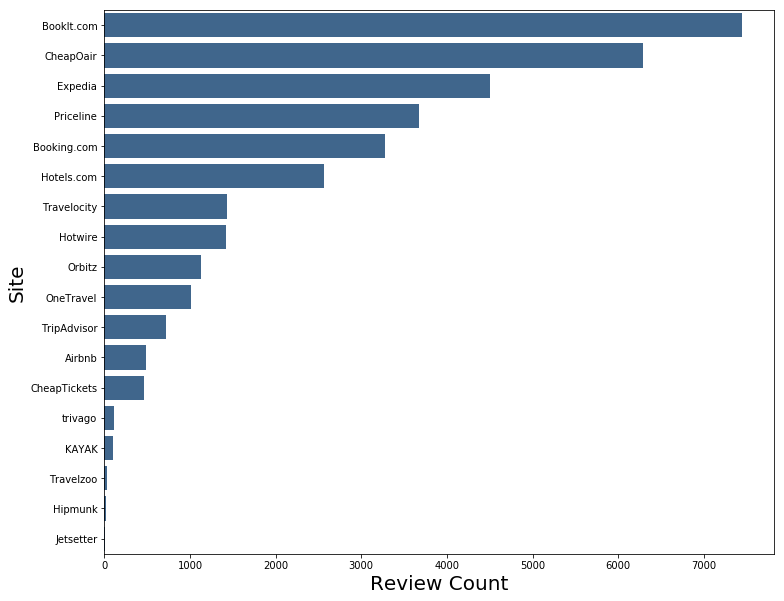

In [77]:
plt.figure(figsize=(12, 10))
g1 = sns.barplot(x=df.site.value_counts(), y=df.site.value_counts().index, color = (0.2, 0.4, 0.6, 0.6))
#ax.set(xlabel='Counts', ylabel='State')
g1.set_xlabel("Review Count",fontsize=20)
g1.set_ylabel("Site",fontsize=20)

In [18]:
# rating and 'helpful' relationship
df.groupby('rating').describe()

helpful                                               
          count      mean       std  min  25%  50%  75%    max
rating                                                        
1.0     14319.0  5.275927  3.974661  2.0  3.0  4.0  6.0   49.0
2.0       590.0  5.194915  4.795758  2.0  2.0  4.0  6.0   72.0
3.0       146.0  4.561644  5.755924  2.0  2.0  3.0  5.0   61.0
4.0       136.0  3.860294  5.959335  2.0  2.0  3.0  4.0   67.0
5.0       371.0  4.439353  8.529026  2.0  2.0  3.0  4.0  115.0

In [19]:
# Total number of 'helpful' in df
df['helpful'].sum()

86229.0

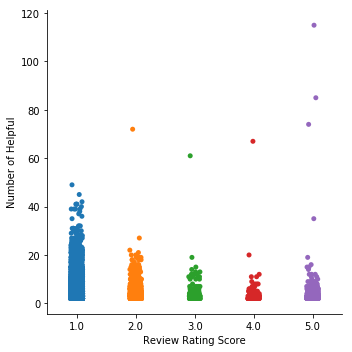

In [20]:
# No. of 'helpful' by rating
g2 = sns.catplot(x="rating", y="helpful", data=df)
g2.set(xlabel='Review Rating Score', ylabel='Number of Helpful')

In [78]:
# Review length by Rating
df['review_length'] = df['text'].apply(lambda x: len(x) - x.count(' '))

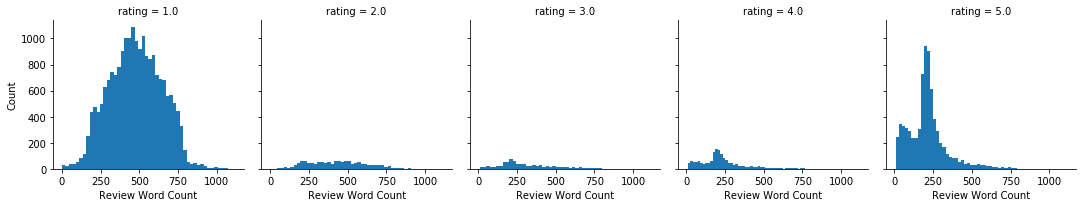

In [79]:
#Review length by Rating
hist = sns.FacetGrid(data=df, col='rating', palette = "Set3")
hist = hist.map(plt.hist, 'review_length', bins=50)
hist.set_axis_labels("Review Word Count", "Count")

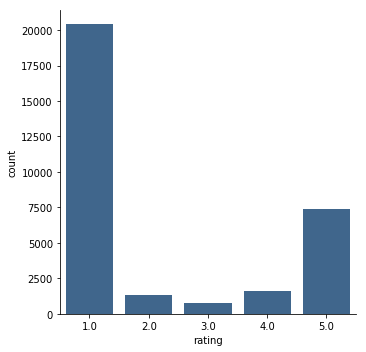

In [80]:
# Overall 'rating' counts 
sns.catplot(x="rating", kind="count", data=df, color = (0.2, 0.4, 0.6, 0.6))

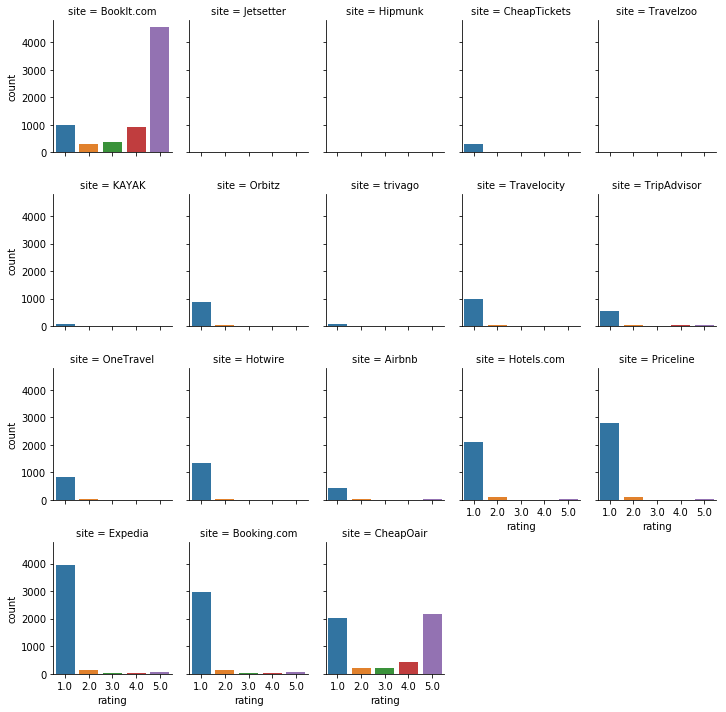

In [81]:
# 'rating' distribution by site
g3 = sns.catplot("rating", col="site", col_wrap=5,
           data=df, kind="count", height=2.5, aspect=.8)

In [83]:
# average 'rating' per site
group = df.groupby('site').agg(['mean'])['rating']
group = group.reset_index()
group = group.sort_values(by = 'mean', ascending = False)
group

site      mean
6        Hipmunk  4.333333
1     BookIt.com  4.086067
9      Jetsetter  3.875000
15     Travelzoo  3.343750
3      CheapOair  3.084242
17       trivago  1.981982
16   TripAdvisor  1.570827
10         KAYAK  1.484536
0         Airbnb  1.281250
11     OneTravel  1.196231
2    Booking.com  1.176343
7     Hotels.com  1.127632
14   Travelocity  1.124411
5        Expedia  1.120525
4   CheapTickets  1.119874
13     Priceline  1.107095
12        Orbitz  1.098485
8        Hotwire  1.073806

Text(0, 0.5, 'Site')

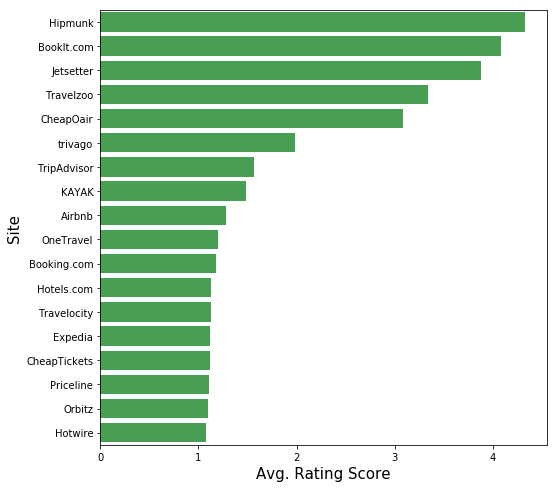

In [84]:
plt.figure(figsize=(8, 8))
g4 = sns.barplot(x='mean', y='site', data =  group, color = sns.xkcd_rgb["medium green"])
#ax.set(xlabel='Counts', ylabel='State')
g4.set_xlabel("Avg. Rating Score",fontsize=15)
g4.set_ylabel("Site",fontsize=15)

# No. of reviews in US and Canada

In [85]:
us_state = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", 
          "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", 
          "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df_us = df.loc[df.state.isin(us_state)]
ca_state = ["AB", "BC", "MB", "NB", "NL", "NT", "NS", "NU", "ON", "PE", "QC", "SK", "YT"]
df_ca = df.loc[df.state.isin(ca_state)]

In [86]:
x = df_us['state'].value_counts()
y = x.to_dict()

Text(0, 0.5, 'State')

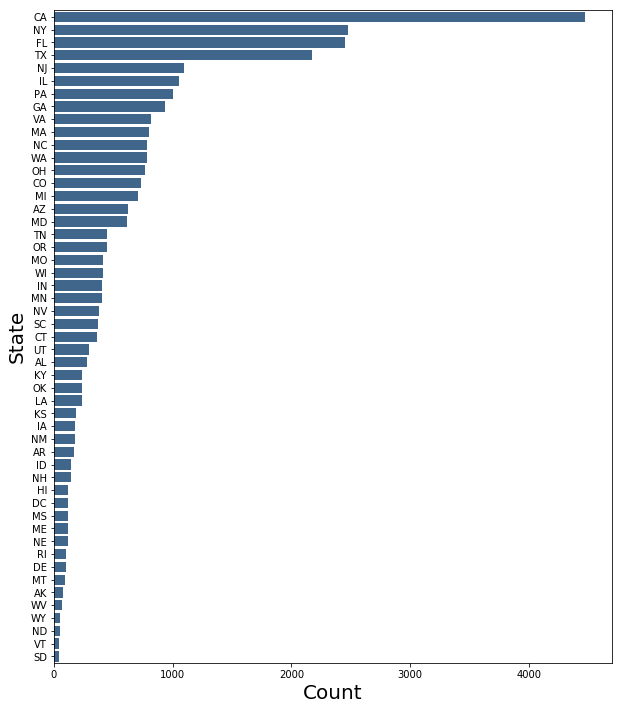

In [88]:
plt.figure(figsize=(10, 12))
g5 = sns.barplot(x=df_us.state.value_counts(), y=df_us.state.value_counts().index, color = (0.2, 0.4, 0.6, 0.6))
#ax.set(xlabel='Counts', ylabel='State')
g5.set_xlabel("Count",fontsize=20)
g5.set_ylabel("State",fontsize=20)

In [89]:
# top 5 sites per State in US
df_us1 = df_us.groupby(['state', 'site']).size().reset_index(name = 'Count')

state_site_list = []
for x in us_state:
    top5_site = df_us1[df_us1['state'] == x].sort_values(by='Count', ascending =False).head(5)
    state_site_list.append(top5_site)
    
top5_site_all = pd.concat(state_site_list)
top5_site_all[top5_site_all['state'] == 'NJ']

state         site  Count
445    NJ   BookIt.com    349
447    NJ    CheapOair    180
449    NJ      Expedia    143
456    NJ    Priceline     88
446    NJ  Booking.com     65

[Text(0, 0.5, 'State'), Text(0.5, 0, 'Counts')]

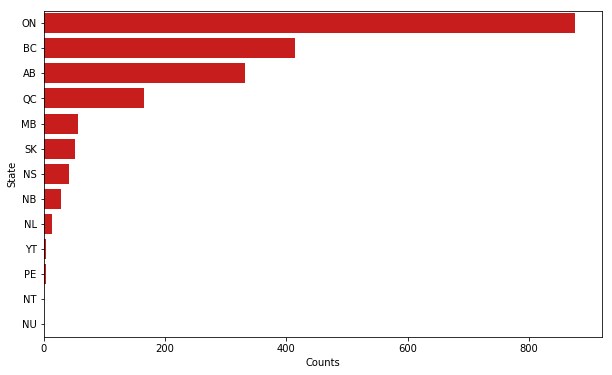

In [90]:
# Canada Result 
plt.figure(figsize=(10,6))
g6 = sns.barplot(x=df_ca.state.value_counts(), y=df_ca.state.value_counts().index, color = sns.xkcd_rgb["red"])
g6.set(xlabel='Counts', ylabel='State')

In [91]:
# top 5 sites per State in Canada
df_ca1 = df_ca.groupby(['state', 'site']).size().reset_index(name = 'Count')

castate_site_list = []
for x in ca_state:
    catop5_site = df_ca1[df_ca1['state'] == x].sort_values(by='Count', ascending =False).head(5)
    castate_site_list.append(catop5_site)
    
catop5_site_all = pd.concat(castate_site_list)
catop5_site_all[catop5_site_all['state'] == 'ON']

state         site  Count
72    ON      Expedia    175
70    ON    CheapOair    166
68    ON   BookIt.com     98
69    ON  Booking.com     84
78    ON    Priceline     69

A Verified Buyer has purchased the reviewed product or service and provided proof of purchase history to ConsumerAffairs. This specification is intended to identify those members of our community who are submitting reviews of products that they own or services they've received. Any proof of purchase information submitted to ConsumerAffairs will not be displayed on our site or used for any other purpose.

A Verified Reviewer has created an account on ConsumerAffairs and confirmed his/her email address through our verification process, has logged in through a social media site like Facebook or Twitter that has confirmed the reviewer's identity, or has been identified by a company that has provided ConsumerAffairs with valid contact information for the reviewer. Verification ensures reviews are written by credible members of the ConsumerAffairs community.

# Percentage Review

In [92]:
# Percentage of 'Non-text review' normalized over the number of reviews
print(sum(df['text']=='')/df.shape[0])

0.013829967758357374


In [36]:
# Percentage of verivied reviewers over the number of reviews
print(sum(df['verified_reviewer'] == 'VerifiedReviewer')/df.shape[0])

0.8028169014084507


In [37]:
# Percentage of verfieid buyer over the number of reviews
print(sum(df['verified_buyer'] == 'VerifiedBuyer')/df.shape[0])

0.45661519316703436


# Text Filtering

In [197]:
# Convert all the string to lower cases
df['text'] = df['text'].str.lower()

# \s+ means all empty space (\n, \r, \t)
df['text'] = df['text'].apply(lambda x: re.sub('\s+',' ', x))

# Remove punctuation
df['text'] = df['text'].apply(lambda x: re.sub('[^\w\s]', '', x))

In [198]:
stop = stopwords.words('english')

In [199]:
stop.extend(['BookIt', 'bookit', 'CheapOair', 'cheapoair', 'Expedia', 'expedia', 'Priceline', 'priceline',
             'Booking.com', 'booking.com','bookingcom', 'Hotels.com', 'hotels.com', 'Travelocity', 'travelocity',
             'Hotwire', 'hotwire', 'Orbitz', 'orbitz', 'OneTravel', 'onetravel', 'TripAdvisor', 'tripadvisor',
             'Airbnb', 'airbnb', 'CheapTickets', 'cheaptickets', 'trivago', 'KAYAK', 'kayak', 'Travelzoo',
             'travelzoo','Hipmunk', 'hipmunk'])

In [200]:
stop =  list(map(str.lower, stop))

In [201]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [43]:
# Define df per site

BookIt = df.loc[df.loc[:,'site']=='BookIt.com',:]
CheapOair = df.loc[df.loc[:,'site']=='CheapOair',:] 
Expedia = df.loc[df.loc[:,'site']=='Expedia',:]
Priceline = df.loc[df.loc[:,'site']=='Priceline',:]
Booking = df.loc[df.loc[:,'site']=='Booking.com',:]
Hotels = df.loc[df.loc[:,'site']=='Hotels.com',:]
Travelocity = df.loc[df.loc[:,'site']=='Travelocity',:]
Hotwire = df.loc[df.loc[:,'site']=='Hotwire',:]
Orbitz = df.loc[df.loc[:,'site']=='Orbitz',:]
OneTravel = df.loc[df.loc[:,'site']=='OneTravel',:]
TripAdvisor = df.loc[df.loc[:,'site']=='TripAdvisor',:]
Airbnb = df.loc[df.loc[:,'site']=='Airbnb',:]
CheapTickets = df.loc[df.loc[:,'site']=='CheapTickets',:]
trivago = df.loc[df.loc[:,'site']=='trivago',:]
KAYAK = df.loc[df.loc[:,'site']=='KAYAK',:]
Travelzoo = df.loc[df.loc[:,'site']=='Travelzoo',:]
Hipmunk = df.loc[df.loc[:,'site']=='Hipmunk',:]

# Stemming and Lemmatization

In [202]:
porter = PorterStemmer()
lancaster = LancasterStemmer()
df['text'] = df['text'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))

lemztr = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemztr.lemmatize(word) for word in x.split()]))

# Bi-grams

In [253]:
# Bigram per Site

BookIt_bi_grams = BookIt['text'].apply(lambda x: TextBlob(x).ngrams(2))
CheapOair_bi_grams = CheapOair['text'].apply(lambda x: TextBlob(x).ngrams(2)) 
Expedia_bi_grams = Expedia['text'].apply(lambda x: TextBlob(x).ngrams(2))
Priceline_bi_grams = Priceline['text'].apply(lambda x: TextBlob(x).ngrams(2))
Booking_bi_grams = Booking['text'].apply(lambda x: TextBlob(x).ngrams(2))
Hotels_bi_grams = Hotels['text'].apply(lambda x: TextBlob(x).ngrams(2))
Travelocity_bi_grams = Travelocity['text'].apply(lambda x: TextBlob(x).ngrams(2))
Hotwire_bi_grams = Hotwire['text'].apply(lambda x: TextBlob(x).ngrams(2))
Orbitz_bi_grams = Orbitz['text'].apply(lambda x: TextBlob(x).ngrams(2))
OneTravel_bi_grams = OneTravel['text'].apply(lambda x: TextBlob(x).ngrams(2))
TripAdvisor_bi_grams = TripAdvisor['text'].apply(lambda x: TextBlob(x).ngrams(2))
Airbnb_bi_grams = Airbnb['text'].apply(lambda x: TextBlob(x).ngrams(2))
CheapTickets_bi_grams = CheapTickets['text'].apply(lambda x: TextBlob(x).ngrams(2))
trivago_bi_grams = trivago['text'].apply(lambda x: TextBlob(x).ngrams(2))
KAYAK_bi_grams = KAYAK['text'].apply(lambda x: TextBlob(x).ngrams(2))
Travelzoo_bi_grams = Travelzoo['text'].apply(lambda x: TextBlob(x).ngrams(2))
Hipmunk_bi_grams = Hipmunk['text'].apply(lambda x: TextBlob(x).ngrams(2))

In [103]:
#Bigram 
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df['text'])
frequencies = sum(sparse_matrix).toarray()[0]
sites_bigram = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [108]:
#Select bigrams with frequency > 500
df_total = sites_bigram.loc[(sites_bigram['frequency'] >= 500)].sort_values('frequency', ascending = False)

In [109]:
df_total = df_total.sort_values(['frequency'], ascending = False).reset_index()

In [110]:
df_total
df_total.columns = ['bigrams', 'frequency']

Text(0, 0.5, 'Frequency')

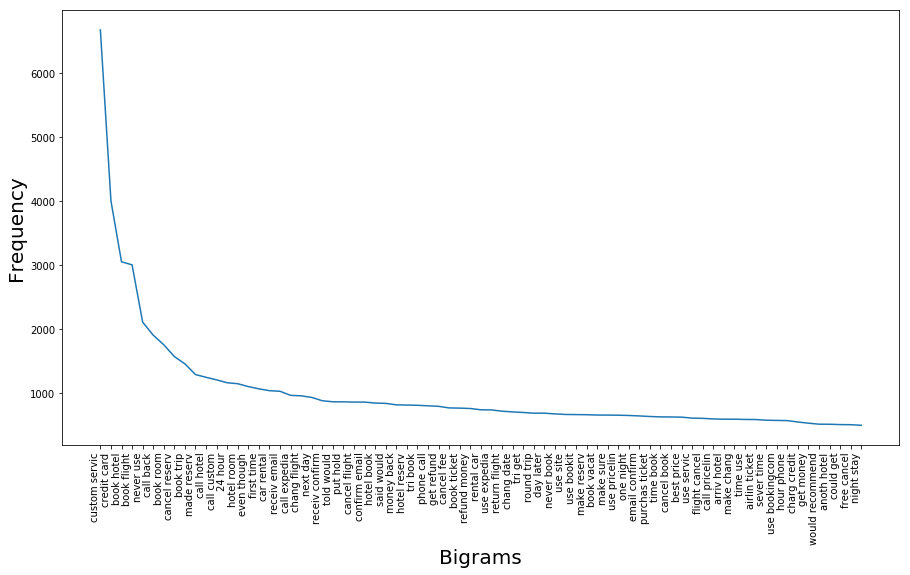

In [111]:
plt.figure(figsize=(15,8))
g7 = sns.lineplot(x='bigrams', y = 'frequency', data =df_total, sort = False, markers = True )
g7.set_xticklabels(df_total.bigrams, rotation = 90, ha="right")
g7.set_xlabel("Bigrams",fontsize=20)
g7.set_ylabel("Frequency",fontsize=20)

# Tri-grams

In [112]:
#trigrams
word_vectorizer = CountVectorizer(ngram_range=(3,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df['text'])
frequencies = sum(sparse_matrix).toarray()[0]
sites_trigram = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [ ]:
#Select bigrams with frequency > 500
df_total3 = sites_trigram.loc[(sites_trigram['frequency'] >= 10)].sort_values('frequency', ascending = False)

In [280]:
df_total3 = df_total_3.sort_values(['frequency'], ascending = False).reset_index()

In [ ]:
df_total3.columns = ['trigrams', 'frequency']

Text(0, 0.5, 'Frequency')

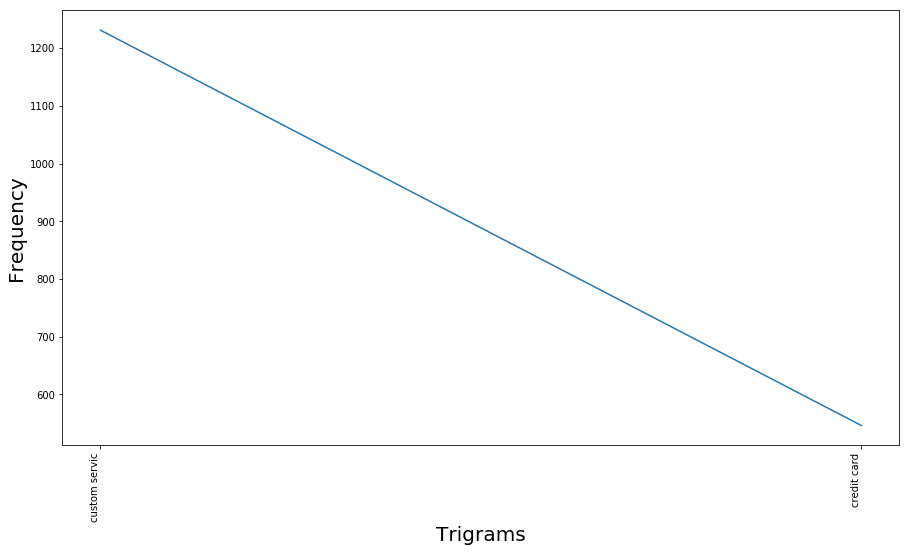

In [282]:
plt.figure(figsize=(15,8))
g8 = sns.lineplot(x='bigrams', y = 'frequency', data =df_total3, sort = False, markers = True )
g8.set_xticklabels(df_total.trigrams, rotation = 90, ha="right")
g8.set_xlabel("Trigrams",fontsize=20)
g8.set_ylabel("Frequency",fontsize=20)

In [ ]:
BookIt_bi_grams = BookIt['text'].apply(lambda x: TextBlob(x).ngrams(3))
CheapOair_bi_grams = CheapOair['text'].apply(lambda x: TextBlob(x).ngrams(3)) 
Expedia_bi_grams = Expedia['text'].apply(lambda x: TextBlob(x).ngrams(3))
Priceline_bi_grams = Priceline['text'].apply(lambda x: TextBlob(x).ngrams(3))
Booking_bi_grams = Booking['text'].apply(lambda x: TextBlob(x).ngrams(3))
Hotels_bi_grams = Hotels['text'].apply(lambda x: TextBlob(x).ngrams(3))
Travelocity_bi_grams = Travelocity['text'].apply(lambda x: TextBlob(x).ngrams(3))
Hotwire_bi_grams = Hotwire['text'].apply(lambda x: TextBlob(x).ngrams(3))
Orbitz_bi_grams = Orbitz['text'].apply(lambda x: TextBlob(x).ngrams(3))
OneTravel_bi_grams = OneTravel['text'].apply(lambda x: TextBlob(x).ngrams(3))
TripAdvisor_bi_grams = TripAdvisor['text'].apply(lambda x: TextBlob(x).ngrams(3))
Airbnb_bi_grams = Airbnb['text'].apply(lambda x: TextBlob(x).ngrams(3))
CheapTickets_bi_grams = CheapTickets['text'].apply(lambda x: TextBlob(x).ngrams(3))
trivago_bi_grams = trivago['text'].apply(lambda x: TextBlob(x).ngrams(3))
KAYAK_bi_grams = KAYAK['text'].apply(lambda x: TextBlob(x).ngrams(3))
Travelzoo_bi_grams = Travelzoo['text'].apply(lambda x: TextBlob(x).ngrams(3))
Hipmunk_bi_grams = Hipmunk['text'].apply(lambda x: TextBlob(x).ngrams(3))

# Bigrams per Rating

In [114]:
# Rating 5 - Bigrams
df_5 = df.loc[df['rating'] == 5]

In [117]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df_5['text'])
frequencies = sum(sparse_matrix).toarray()[0]
df5_bigram_score = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [118]:
#Select bigrams with frequency > 500
df_5 = df5_bigram_score.loc[(df5_bigram_score['frequency'] >= 100)].sort_values('frequency', ascending = False)

In [119]:
df_5 = df5_bigram_score.sort_values(['frequency'], ascending = False).reset_index()

In [120]:
df_5.columns = ['bigrams', 'frequency']

In [121]:
df_5_top30 = df_5.head(30)

Text(0, 0.5, 'Frequency')

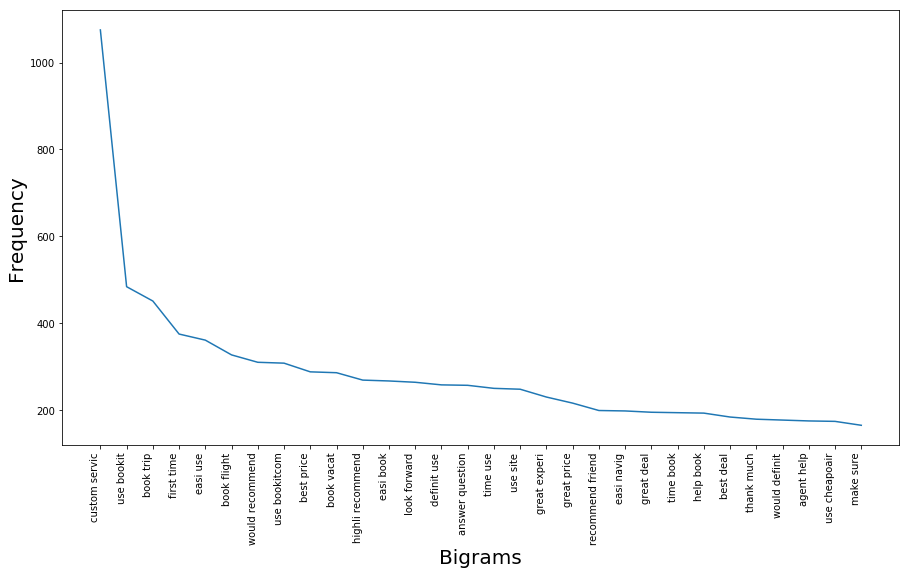

In [122]:
plt.figure(figsize=(15,8))
g9 = sns.lineplot(x='bigrams', y = 'frequency', data =df_5_top30, sort = False)
g9.set_xticklabels(df_5.bigrams, rotation = 90, ha="right")
g9.set_xlabel("Bigrams",fontsize=20)
g9.set_ylabel("Frequency",fontsize=20)

In [115]:
# Rating 1 - Bigrams
df_1 = df.loc[df['rating'] == 1]

In [123]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df_1['text'])
frequencies = sum(sparse_matrix).toarray()[0]
df1_bigram_score = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [124]:
#Select bigrams with frequency > 100
df_1 = df1_bigram_score.loc[(df1_bigram_score['frequency'] >= 100)].sort_values('frequency', ascending = False)

In [125]:
df_1 = df1_bigram_score.sort_values(['frequency'], ascending = False).reset_index()

In [126]:
df_1.columns = ['bigrams', 'frequency']

In [127]:
df_1_top30 = df_1.head(30)

Text(0, 0.5, 'Frequency')

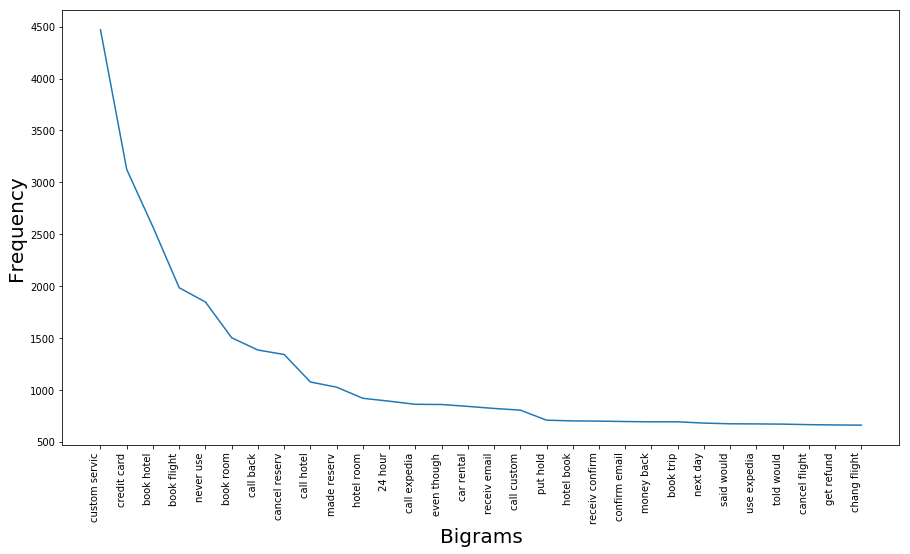

In [128]:
plt.figure(figsize=(15,8))
g10 = sns.lineplot(x='bigrams', y = 'frequency', data =df_1_top30, sort = False)
g10.set_xticklabels(df_1.bigrams, rotation = 90, ha="right")
g10.set_xlabel("Bigrams",fontsize=20)
g10.set_ylabel("Frequency",fontsize=20)

# Common bigrams in both rating = 5 & rating =1 reviews 

In [129]:
inner_join_bigrams = pd.concat([df_5.set_index('bigrams'),df_1.set_index('bigrams')], axis=1, join='inner')
inner_join_bigrams.columns = ['5 star rating frequency', '1 star rating frequency']

In [130]:
inner_join_bigrams.head(30)

5 star rating frequency  1 star rating frequency
bigrams                                                           
custom servic                        1075                     4470
use bookit                            484                       60
book trip                             451                      692
first time                            375                      484
easi use                              361                       13
book flight                           327                     1984
would recommend                       310                      139
use bookitcom                         308                       70
best price                            288                      251
book vacat                            286                      263
highli recommend                      269                       51
easi book                             267                       10
look forward                          264                       39
definit use                           258                        4
answer question                       257                       65
time use                              250                      246
use site                              248                      318
great experi                          230                       16
great price                           216                       44
recommend friend                      199                        9
easi navig                            198                        3
great deal                            195                      112
time book                             194                      325
help book                             193                       81
best deal                             184                       56
thank much                            179                       11
would definit                         177                       21
agent help                            175                       25
use cheapoair                         174                      126
make sure                             165                      385

# Word Cloud

In [314]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
# generate word cloud
wc.generate(' '.join(df['text']))

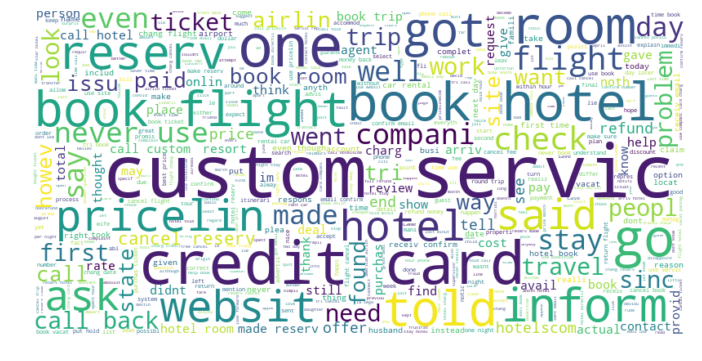

In [315]:
# show
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

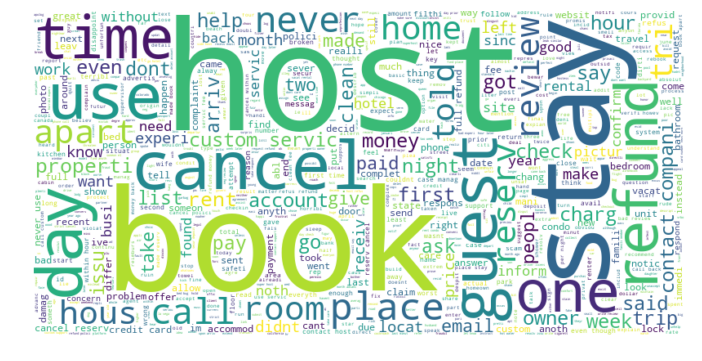

In [313]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Airbnb['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

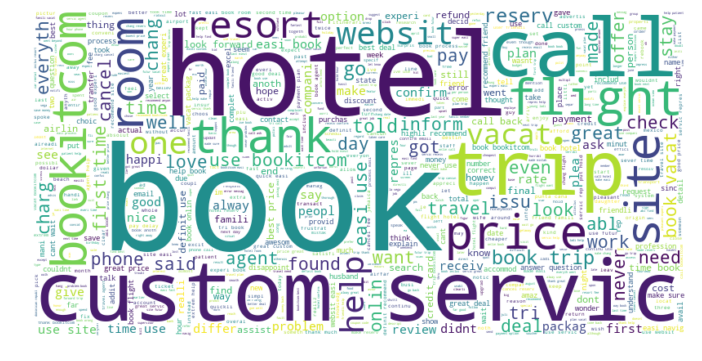

In [316]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(BookIt['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

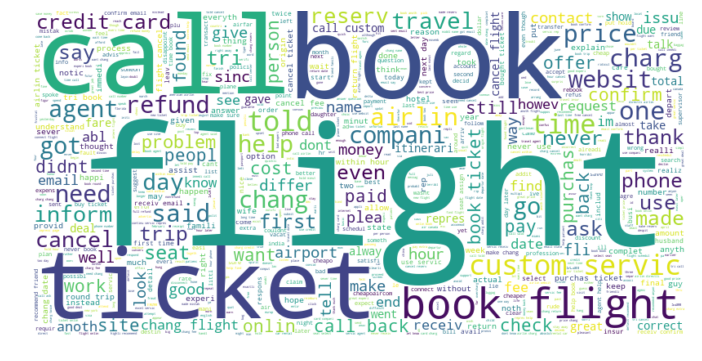

In [317]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(CheapOair['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

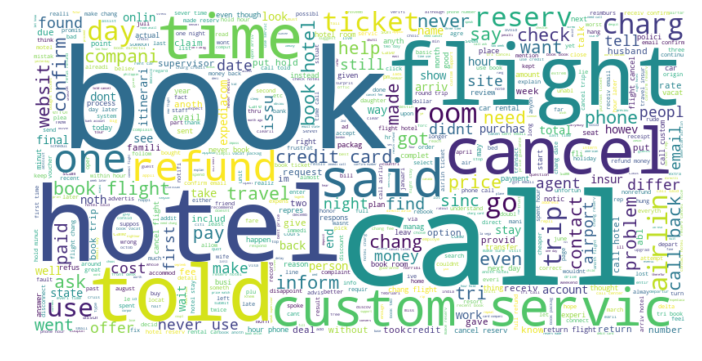

In [318]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Expedia['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

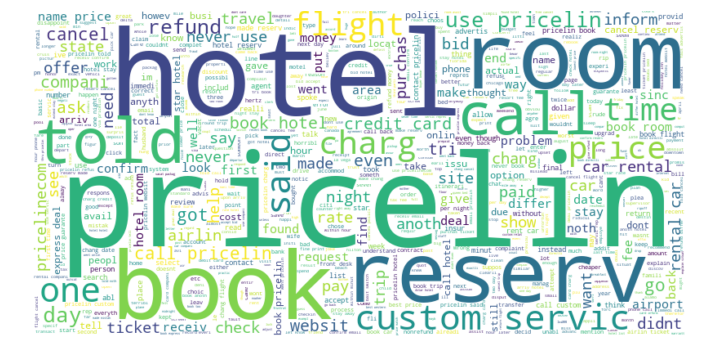

In [319]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Priceline['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

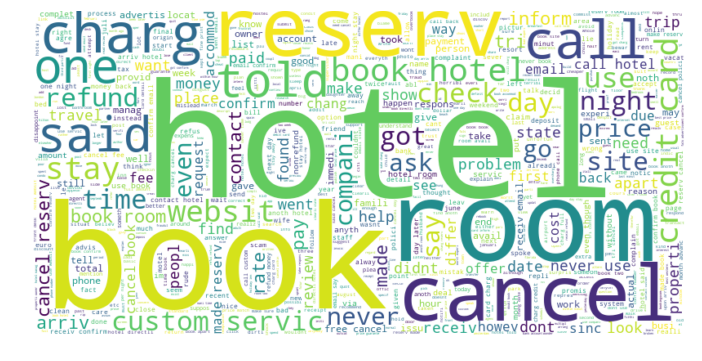

In [320]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Booking['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

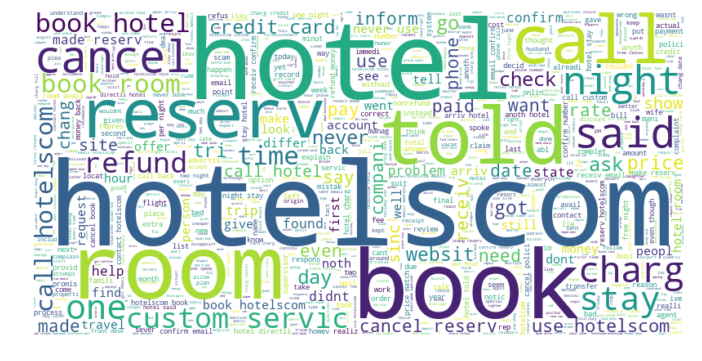

In [321]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Hotels['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

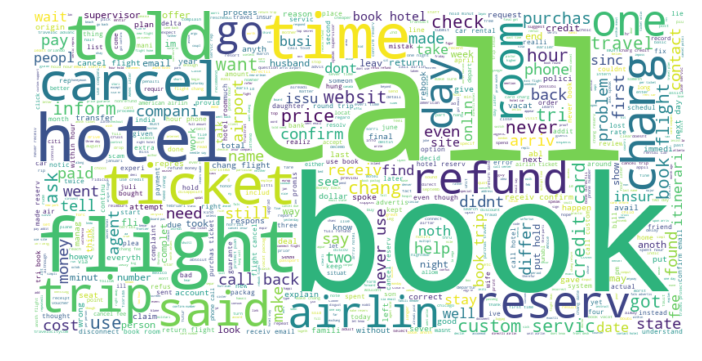

In [322]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Travelocity['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

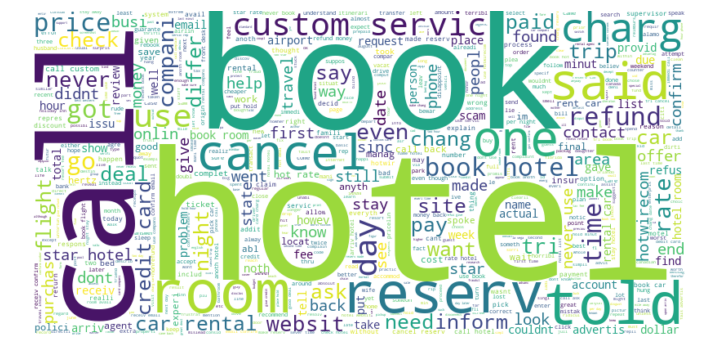

In [323]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Hotwire['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

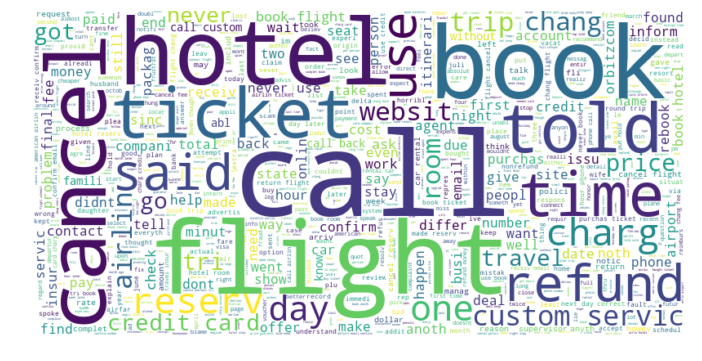

In [324]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Orbitz['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

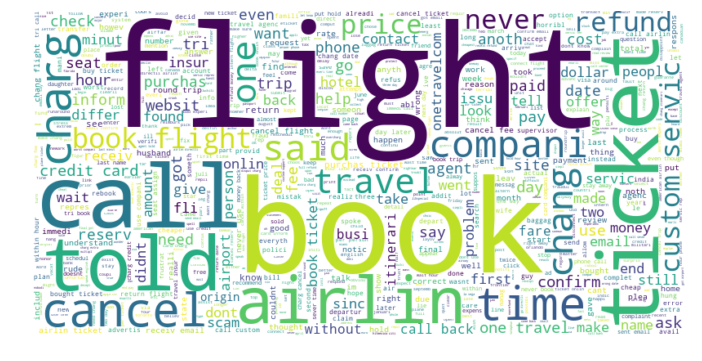

In [325]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(OneTravel['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

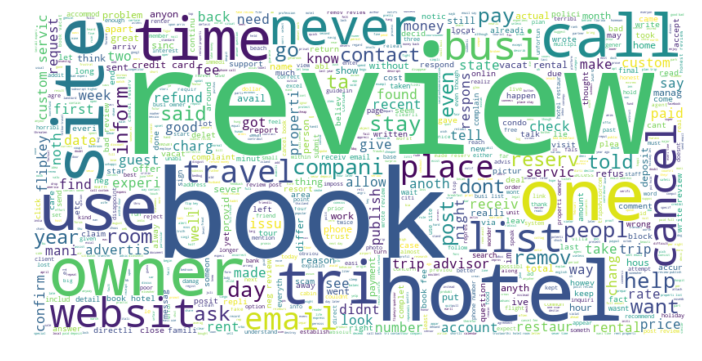

In [326]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(TripAdvisor['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

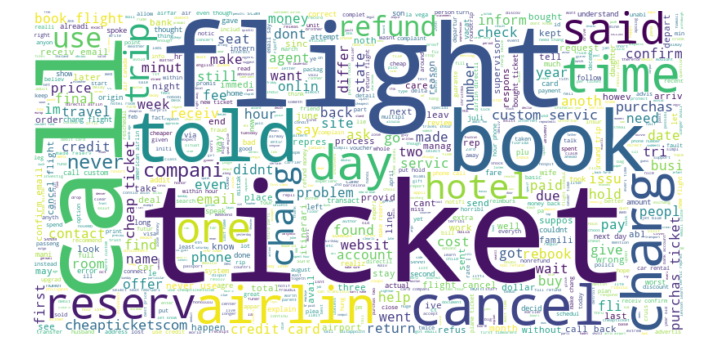

In [327]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(CheapTickets['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

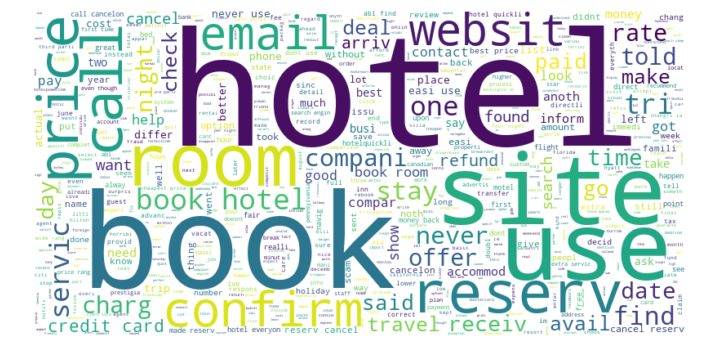

In [328]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(trivago['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

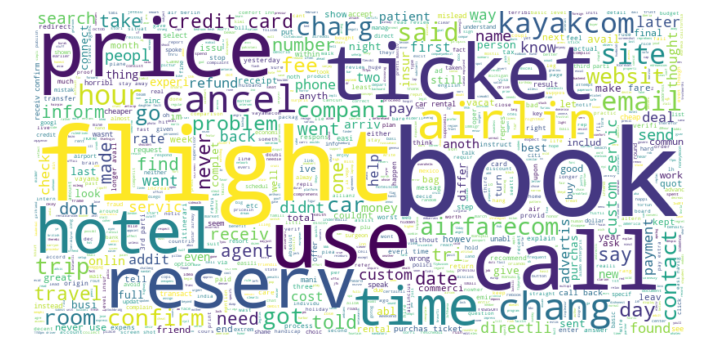

In [329]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(KAYAK['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

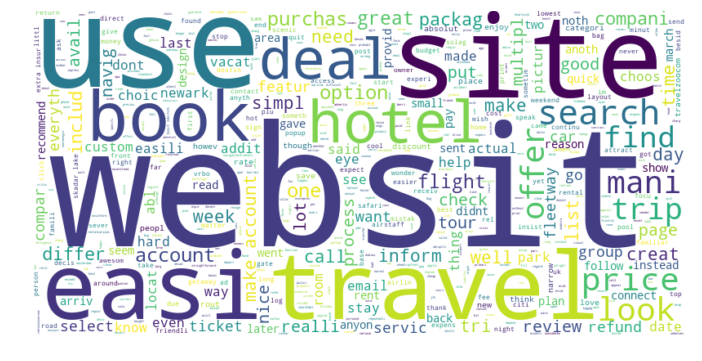

In [330]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Travelzoo['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

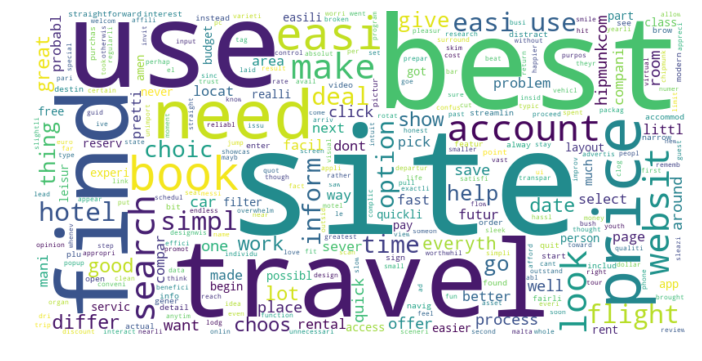

In [331]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
wc.generate(' '.join(Hipmunk['text']))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis

In [566]:
sample_size = 4000

def sentiment_func(x):
    sentiment = TextBlob(x['text'])
    x['polarity'] = sentiment.polarity
    x['subjectivity'] = sentiment.subjectivity
    return x

sample = df.sample(sample_size).apply(sentiment_func, axis=1)

In [567]:
sample

helpful  rating review_date         site  \
32354      3.0     1.0  2015-02-19    CheapOair   
4071       NaN     5.0  2015-10-17          NaN   
27702      NaN     NaN  2008-02-27    Priceline   
21844      4.0     1.0  2014-04-16    Priceline   
19403      2.0     1.0  2016-07-12  Booking.com   
11757      2.0     1.0  2018-02-21      Expedia   
4277       NaN     1.0  2019-02-13      Expedia   
5389      18.0     1.0  2017-02-22    OneTravel   
16136      NaN     2.0  2018-05-19   BookIt.com   
31151      2.0     NaN  2015-10-08    CheapOair   
7880       5.0     1.0  2018-07-07    Priceline   
25192      NaN     4.0  2017-04-08   BookIt.com   
878        NaN     5.0  2019-06-16  Booking.com   
16911      NaN     4.0  2018-01-30    CheapOair   
7777      15.0     1.0  2015-05-27  TripAdvisor   
5529       3.0     1.0  2018-12-29      Expedia   
16347      2.0     1.0  2017-05-05  Booking.com   
17890      3.0     1.0  2016-10-02      Expedia   
31358      NaN     5.0  2016-06-10   BookIt.com   
32145      NaN     5.0  2016-05-19   BookIt.com   
25499      NaN     5.0  2017-03-24   BookIt.com   
16851      NaN     5.0  2018-04-16   BookIt.com   
24722      5.0     1.0  2014-07-28  Booking.com   
6443       4.0     1.0  2018-12-17  Booking.com   
2106       4.0     1.0  2019-04-18   Hotels.com   
20534      NaN     2.0  2012-05-08   Hotels.com   
11472      NaN     1.0  2018-02-28      Expedia   
32992      NaN     4.0  2016-04-25   BookIt.com   
28819      9.0     1.0  2013-12-28      Expedia   
22137      3.0     1.0  2017-04-08    CheapOair   
...        ...     ...         ...          ...   
8653       7.0     1.0  2018-08-03      Expedia   
3264      11.0     1.0  2017-07-05  TripAdvisor   
4970      17.0     1.0  2017-05-09    OneTravel   
3617       3.0     1.0  2017-07-04  Travelocity   
21623      NaN     NaN  2011-06-29   Hotels.com   
26999      NaN     NaN  2009-02-22    Priceline   
25519      NaN     4.0  2017-03-20   BookIt.com   
10685      4.0     1.0  2013-05-28       Orbitz   
24286      5.0     1.0  2014-09-30  Booking.com   
11370      2.0     1.0  2015-09-01      Hotwire   
14860      5.0     1.0  2015-06-17   Hotels.com   
4883       3.0     1.0  2016-10-26  Travelocity   
25173      7.0     1.0  2014-05-01  Booking.com   
23361     13.0     1.0  2015-04-10  Booking.com   
813        NaN     1.0  2019-05-30    Priceline   
6452       3.0     1.0  2018-12-12  Booking.com   
17729      3.0     1.0  2016-10-08      Expedia   
7380       2.0     5.0  2015-01-14          NaN   
27514      7.0     1.0  2014-12-04      Expedia   
10623      8.0     1.0  2018-06-22  Booking.com   
34956      NaN     5.0  2016-01-05   BookIt.com   
26861      NaN     NaN  2009-05-13    Priceline   
21763      NaN     5.0  2017-05-04    CheapOair   
27479      NaN     NaN  2008-06-20    Priceline   
30991      NaN     5.0  2016-06-24   BookIt.com   
34501      NaN     5.0  2016-03-11   BookIt.com   
2613       3.0     1.0  2019-04-15      Expedia   
21599      NaN     5.0  2017-05-09    CheapOair   
23854      NaN     5.0  2017-06-16   BookIt.com   
20379      5.0     1.0  2014-11-30    Priceline   

                                                    text verified_buyer  \
32354  I booked tickets on Valentine's Day for my hus...  VerifiedBuyer   
4071   I was looking for a particular tour online and...  VerifiedBuyer   
27702  I booked a hotel on priceline.com for an upcom...                  
21844  I decided to use Priceline for the first time ...                  
19403  Stay away from Swiss Star hotels and booking.c...  VerifiedBuyer   
11757  I am a volunteer U-14 girl's volleyball coach....  VerifiedBuyer   
4277   My wife booked a trip to the US with hotel, fl...                  
5389   I should have read the reviews 1st! They are a...  VerifiedBuyer   
16136  I am taking my two children, their spouses and...  VerifiedBuyer   
31151  I was deciding whether to change my family's r...  VerifiedBuyer   
7880   My boyfriend

Text(0, 0.5, 'Polarity')

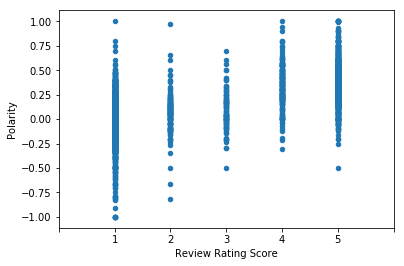

In [568]:
sample.plot.scatter('rating', 'polarity')
plt.xticks(np.arange(7), ('', '1', '2', '3', '4', '5',''))
plt.xlabel('Review Rating Score')
plt.ylabel('Polarity')

# Detecting good, neutral, and bad reviews

In [151]:


def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["text_clean"] = df["text"].apply(lambda x: clean_text(x))

In [155]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["text"].apply(lambda x: sid.polarity_scores(x))

In [ ]:
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [108]:
# add number of characters column
df["nb_chars"] = df["text"].apply(lambda x: len(x))

In [109]:
# add number of words column
df["nb_words"] = df["text"].apply(lambda x: len(x.split(" ")))

In [122]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["text", "pos"]].head(10)

text    pos
29411             Great people, great service... thanks!  0.851
34861            Excellent, friendly service. Very kind.  0.841
8116           Great customer service, easy, responsive.  0.826
34655          Definitely will recommend & great prices.  0.823
31300  Nice and easy process. Safe and great pricing....  0.817
28951  Excellent service, 100% satisfaction, happy al...  0.815
29663               Easy and good communication. Thanks.  0.813
30338          I would definitely recommend to a friend!  0.813
31775                 Yes I would recommend to a friend.  0.808
29664                       Great price - great service.  0.804

In [111]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["text", "neg"]].head(10)

text    neg
33931                             A vacation from hell.   0.697
32991  Needed an extra day. No problem. Fast booking,...  0.620
6197   My professionally edited negative review was r...  0.583
2146   They will never change or cancel hotel reserva...  0.568
30744  I really disappointed about BookIt. Not help a...  0.566
31465                 I had no problems booking my trip.  0.551
32182  I made a mistake and they corrected it with no...  0.549
24244  They charged me for a reservation I did not wa...  0.512
3935                                The place is a dump!  0.491
30988      Had no difficulties booking. Would use again.  0.468

In [113]:
df["is_bad_review"] = df["rating"].apply(lambda x: -1 if x < 3 else (0 if x==3 else 1))

In [114]:
df2 = df[["text", "is_bad_review"]]
df2.head()

text  is_bad_review
0  Just saved $600. on BookIt vs. another web sit...              1
1  I had a great experience with BookIt. I needed...              1
2  I have had nothing but courteous patient and w...              1
3  I just want to let you know that I had talked ...              1
4  I called to verify one of the All Inclusive Fe...              1

In [115]:
# show is_bad_review distribution
df["is_bad_review"].value_counts(normalize = True)

-1    0.613836
 1    0.363991
 0    0.022173
Name: is_bad_review, dtype: float64

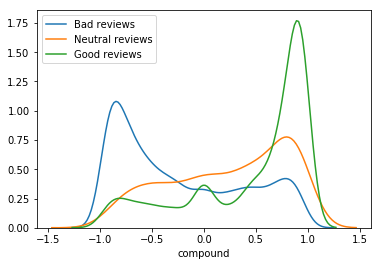

In [134]:
for x in [-1, 0, 1]:
    subset = df[df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == -1:
        label = "Bad reviews"
    elif x == 0:
        label = "Neutral reviews"
    else:
        label = "Good reviews"
    sns.distplot(subset['compound'], hist = False, label = label)
    
    

# TF-IDF Analysis

In [147]:
corpus = df['text']
# settings for count vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

# corpus into tfidf vectorizer
tfidf_vectors = tfidf_vectorizer.fit_transform(corpus)

In [146]:
fitted_vectorizer=tfidf_vectorizer.fit(corpus)
tfidf_vectorizer_vectors=fitted_vectorizer.transform(corpus)

In [210]:
# get the first vector
first_tfidf_vector = tfidf_vectors[1]

# calculate tf-idf values
df_tfidf = pd.DataFrame(first_tfidf_vector[0].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df_tfidf.sort_values(by=["tfidf"],ascending=False)

tfidf
bookit               0.418867
need                 0.345017
quick                0.298585
futur                0.252259
save                 0.248597
lot                  0.244063
use                  0.241907
repres               0.216268
recommend            0.203578
easi                 0.196832
great                0.194349
found                0.187589
experi               0.183258
money                0.172095
websit               0.167768
help                 0.155409
chang                0.154896
flight               0.131212
would                0.127328
midconvers           0.000000
midday               0.000000
middecemb            0.000000
middl                0.000000
midcal               0.000000
00                   0.000000
midbook              0.000000
midaugust            0.000000
midair               0.000000
middleeast           0.000000
midafternoon         0.000000
...                       ...
bethink              0.000000
bethesda             0.000000
beth                 0.000000
bet                  0.000000
bgh                  0.000000
bhagwanda            0.000000
bike                 0.000000
bhm                  0.000000
bigup                0.000000
biggi                0.000000
biggest              0.000000
bigger               0.000000
big4                 0.000000
big                  0.000000
bienvil              0.000000
bidet                0.000000
bide                 0.000000
biddingfortravelcom  0.000000
bidder               0.000000
bidbuy               0.000000
bid                  0.000000
bicom                0.000000
bicol                0.000000
bicker               0.000000
bichon               0.000000
bibl                 0.000000
bias                 0.000000
bia                  0.000000
bht                  0.000000
隠庵                   0.000000

[26075 rows x 1 columns]

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
 
vectorizer = CountVectorizer().fit_transform(corpus)
norm_count = normalize(vectorizer, norm='l1', axis=1)
 
tfidf = TfidfVectorizer()
tf = tfidf.fit_transform(corpus)
tf = norm_count.multiply(tfidf.idf_)
 
feature_names = tfidf.get_feature_names()
doc_index = [i for i in corpus]
df = pd.DataFrame(tf.T.todense(), index=feature_names, columns=doc_index)
print("Text : \n", corpus)
print("\nTerm frequency : \n",tf)
print("\nInverse document frequency : \n",tfidf.idf_)
print("\nTerm frequency - inverse document frequency : \n",df)

Text : 
 0        save 600 bookit v anoth web site use bookit ma...
1        great experi bookit need help chang flight rep...
2        noth courteou patient will help advisor ive al...
3        want let know talk anoth coupl decid book comp...
4        call verifi one inclus featur comment descript...
5        book packag vacat black friday special sunday ...
6        search websit go away vacat week price continu...
7        aruba vacat far easi believ got realli good de...
8        use bookitcom reserv resort punta cana alway g...
9        ive alway great experi bookitcom great price p...
10       easi navig help would definit use futur vacat ...
11       good experi book hotel part done phone complet...
12       experi bookit except date problem would recomm...
13       bookit nice websit purchas allinclus reason va...
14       enjoy trip overal first inclus vacat howev dis...
15       super earli book great discount round trip tra...
16       cant leav accur review yet say love pr